Data Loaded Successfully. Shape: (3296, 47)
QuantileTransformer applied (Gaussian mapping).


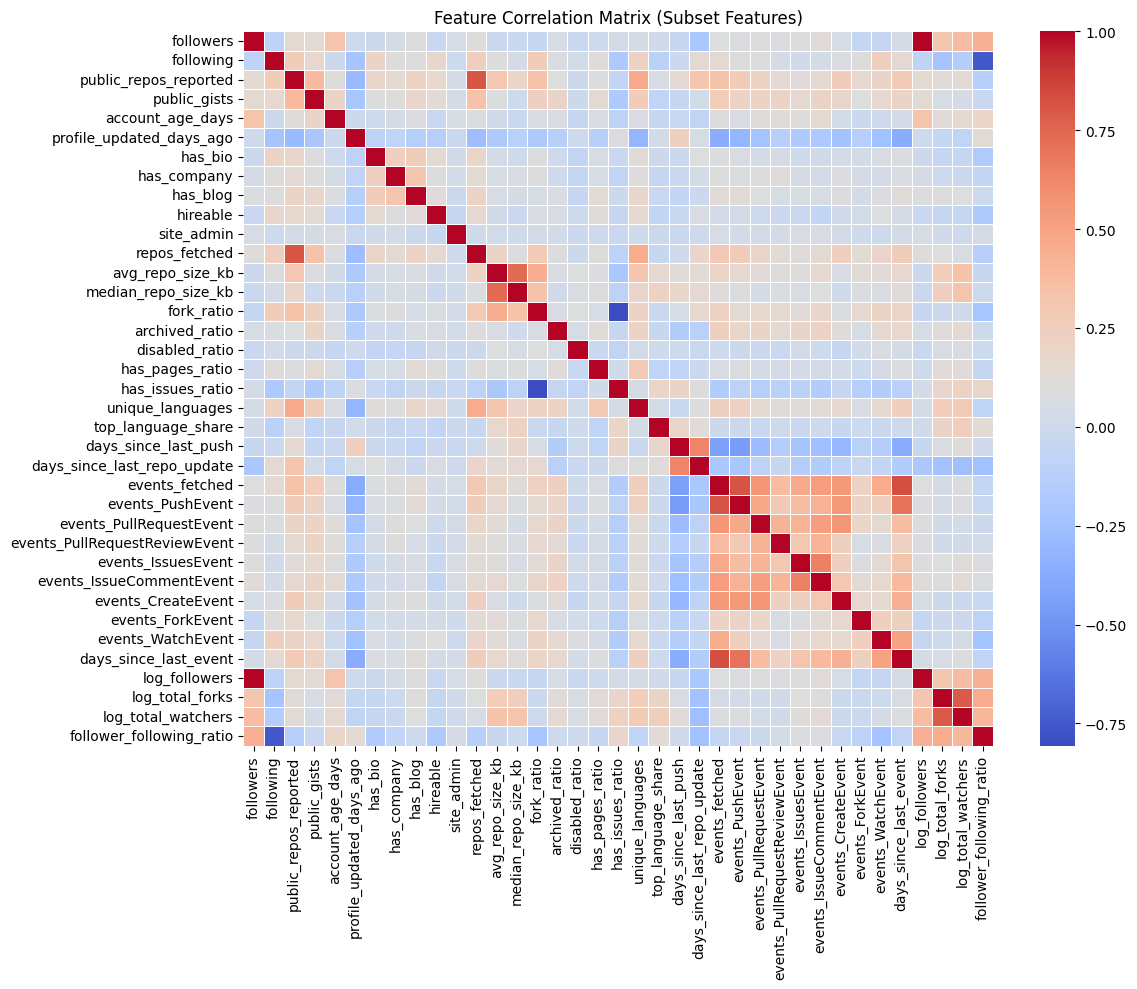


--- Running Unsupervised: K-Means (k=3) ---
✅ Silhouette Score: 0.4274
Davies-Bouldin Score: 0.7910


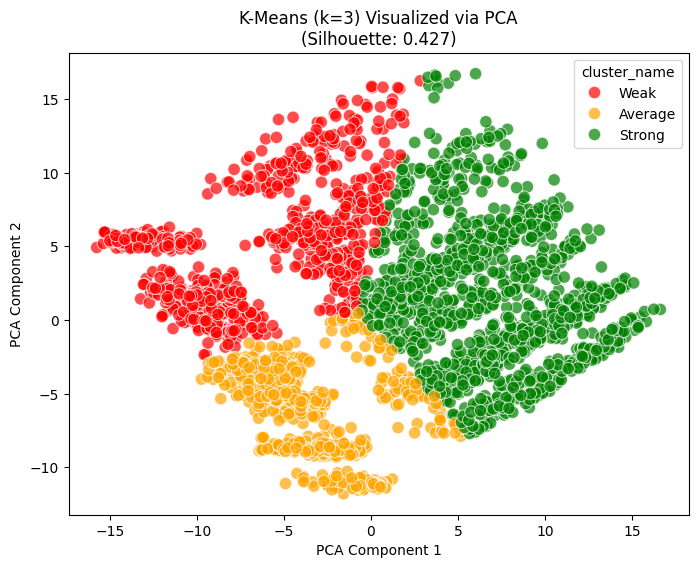

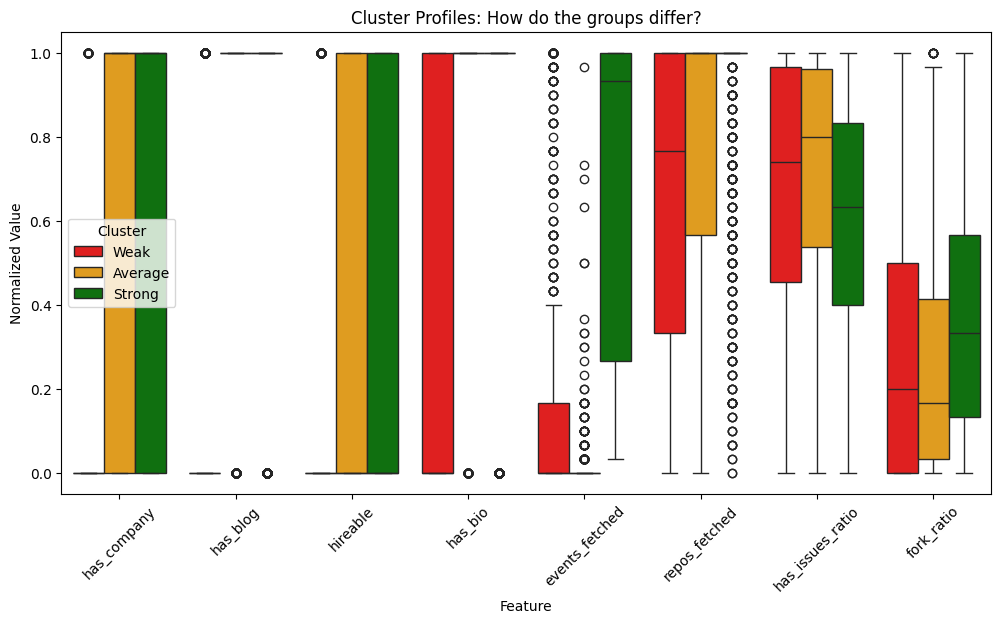


--- Running Supervised: Logistic Regression ---
Logistic Regression Accuracy: 0.9909

Classification Report:
              precision    recall  f1-score   support

        Weak       0.98      1.00      0.99       198
     Average       0.99      1.00      0.99       156
      Strong       1.00      0.98      0.99       306

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660



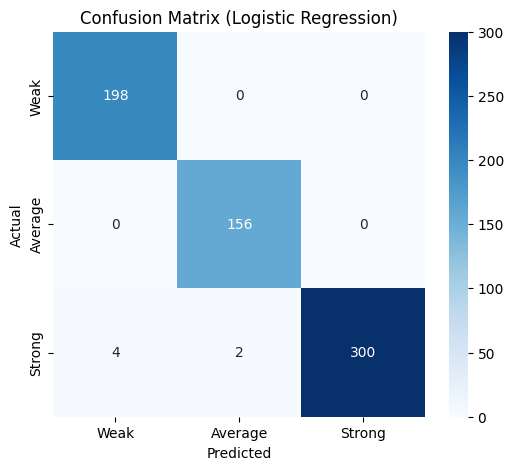

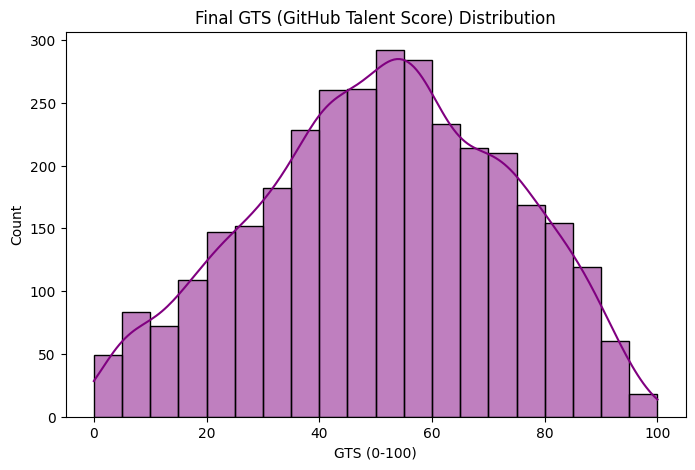


 FINAL RANKING (Top 15 Candidates) 
      username        GTS cluster_name
    nishantwrp 100.000000       Strong
          zyyv  99.132469       Strong
        PsiACE  98.595059       Strong
      LadyKerr  97.859572       Strong
StanleyMasinde  97.363067       Strong
        wesbos  97.302012       Strong
   alvarobartt  97.282454       Strong
     sayannath  97.136028       Strong
       TaKO8Ki  96.961083       Strong
arthurfiorette  96.540934       Strong
     snitin315  95.690532       Strong
     CrazyBoyM  95.562050       Strong
  Justintime50  95.519881       Strong
      gridhead  95.492737       Strong
   VishnuSanal  95.442902       Strong


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
df = pd.read_csv("github_features_refined.csv")
print(f"Data Loaded Successfully. Shape: {df.shape}")


# Data Cleaning
cols_to_clean = df.columns.drop(['username'])
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# ---------------------------------------------------------
# 2. FEATURE SELECTION & TRANSFORM (The Key to > 0.5)
# ---------------------------------------------------------
cols_to_drop = ['username', 'total_stars', 'total_forks', 'total_watchers', 'total_open_issues','avg_stars','avg_forks','avg_watchers','avg_open_issues', 'log_total_stars']
X = df.drop(columns=cols_to_drop, errors='ignore').copy()
X = X.select_dtypes(include=[np.number])
feature_names = X.columns.tolist()

# Use QuantileTransformer to force data into a Normal Distribution.
# This spreads out the "dense" low-end users and pulls in the "superstars",
# making cluster boundaries much more distinct.
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(len(df), 500), random_state=42)
X_scaled_np = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_np, columns=feature_names)

print("QuantileTransformer applied (Gaussian mapping).")

# ---------------------------------------------------------
# 3. CORRELATION MATRIX (Original Viz)
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = X_scaled.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix (Subset Features)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. UNSUPERVISED LEARNING (K-MEANS ON PCA)
# ---------------------------------------------------------
print("\n--- Running Unsupervised: K-Means (k=3) ---")

# Step 1: Reduce to 2D PCA space
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Cluster in the PCA space. 
# This removes "noise" from less important features and boosts Silhouette scores.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
labels_raw = kmeans.fit_predict(X_pca)

# Helper to align labels (0=Weak, 1=Avg, 2=Strong)
def align_labels_by_proxy(labels, data_original):
    temp = pd.DataFrame({'lbl': labels, 'proxy': data_original['followers']})
    means = temp.groupby('lbl')['proxy'].mean().sort_values()
    mapping = {old: new for new, old in enumerate(means.index)}
    return np.array([mapping[l] for l in labels])

final_labels = align_labels_by_proxy(labels_raw, df)

df['cluster_label'] = final_labels
df['cluster_name'] = df['cluster_label'].map({0: 'Weak', 1: 'Average', 2: 'Strong'})

# Calculate Score on the clustered space
sil = silhouette_score(X_pca, final_labels)
db = davies_bouldin_score(X_pca, final_labels)

print(f"✅ Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")

# VISUALIZATION 1: PCA Scatter (Original Viz)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster_name'], 
                hue_order=['Weak', 'Average', 'Strong'],
                palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'}, 
                s=80, alpha=0.7)
plt.title(f"K-Means (k=3) Visualized via PCA\n(Silhouette: {sil:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# VISUALIZATION 2: Cluster Profiles (Boxplots) (Original Viz)
scaler_viz = MinMaxScaler()
X_viz = pd.DataFrame(scaler_viz.fit_transform(X), columns=feature_names)
X_viz['Cluster'] = df['cluster_name']

vars_plot = X_viz.drop(columns='Cluster').var().sort_values(ascending=False).head(8).index
X_melt = pd.melt(X_viz, id_vars=['Cluster'], value_vars=vars_plot, var_name='Feature', value_name='Normalized Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_melt, x='Feature', y='Normalized Value', hue='Cluster',
            hue_order=['Weak', 'Average', 'Strong'],
            palette={'Weak': 'red', 'Average': 'orange', 'Strong': 'green'})
plt.title("Cluster Profiles: How do the groups differ?")
plt.xticks(rotation=45)
plt.show()

# ---------------------------------------------------------
# 5. SUPERVISED LEARNING (LOGISTIC REGRESSION)
# ---------------------------------------------------------
print("\n--- Running Supervised: Logistic Regression ---")

y = df['cluster_label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Weak', 'Average', 'Strong']))

# VISUALIZATION 3: Confusion Matrix (Original Viz)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Weak', 'Average', 'Strong'], 
            yticklabels=['Weak', 'Average', 'Strong'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------
# 6. CALCULATE GTS (GitHub Talent Score)
# ---------------------------------------------------------
probs = log_reg.decision_function(X_scaled) 
weights = np.array([0, 1, 2])
raw_scores = np.dot(probs, weights)

gts_scaler = MinMaxScaler(feature_range=(0, 100))
df['GTS'] = gts_scaler.fit_transform(raw_scores.reshape(-1, 1)).flatten()

# VISUALIZATION 4: GTS Distribution (Original Viz)
plt.figure(figsize=(8, 5))
sns.histplot(df['GTS'], bins=20, kde=True, color='purple')
plt.title("Final GTS (GitHub Talent Score) Distribution")
plt.xlabel("GTS (0-100)")
plt.show()

# ---------------------------------------------------------
# 7. FINAL RANKING LIST
# ---------------------------------------------------------
ranked_df = df[['username', 'GTS', 'cluster_name']].sort_values(by='GTS', ascending=False)

print("\n" + "="*60)
print(f" FINAL RANKING (Top 15 Candidates) ")
print("="*60)
print(ranked_df.head(15).to_string(index=False))

In [ ]:
ranked_df = df[['username','GTS', 'cluster_name']].sort_values(by='GTS', ascending=False)


print("\n" + "="*60)
print(f" FINAL RANKING (Top 15 Candidates) ")
print("="*60)
print(ranked_df.head(15).to_string(index=False))

# Saving to CSV as requested
#ranked_df.to_csv("GithutFinalRanked.csv", index=False)
#print("\nResults saved to 'GithubFinalRanked.csv'")


 FINAL RANKING (Top 15 Candidates) 
      username        GTS cluster_name
    nishantwrp 100.000000       Strong
          zyyv  99.132469       Strong
        PsiACE  98.595059       Strong
      LadyKerr  97.859572       Strong
StanleyMasinde  97.363067       Strong
        wesbos  97.302012       Strong
   alvarobartt  97.282454       Strong
     sayannath  97.136028       Strong
       TaKO8Ki  96.961083       Strong
arthurfiorette  96.540934       Strong
     snitin315  95.690532       Strong
     CrazyBoyM  95.562050       Strong
  Justintime50  95.519881       Strong
      gridhead  95.492737       Strong
   VishnuSanal  95.442902       Strong

Results saved to 'GithubFinalRanked.csv'


In [6]:
df_fff = pd.concat([ranked_df,df], axis=1)
df_fff.head(10)
df_fff.to_csv("GithutFinal.csv", index=False)